# Library

In [3]:
# libraries

import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
import matplotlib.pyplot as plt
from matplotlib import rcParams

from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest

# Loading Data

In [4]:
# dataset
df = pd.read_csv("machine_temperature_system_failure.csv")
df.head()

,timestamp,value
0,2013-12-02 21:15:00,73.967322
1,2013-12-02 21:20:00,74.935882
2,2013-12-02 21:25:00,76.124162
3,2013-12-02 21:30:00,78.140707
4,2013-12-02 21:35:00,79.329836


In [5]:
# Data type and Missing value check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


There seems to be no missing values in our data

In [6]:
df.describe(include = "object")

,timestamp
count,22695
unique,22683
top,2014-01-07 02:45:00
freq,2


There are **22683** unique values from **22695** total data, it means there are at least 12 duplicated data. Since it's lower than 1% of the total data, we'll drop it later

In [7]:
df.describe(percentiles = [.01,.05, .75, .25])

,value
count,22695.000000
mean,85.926498
std,13.746912
min,2.084721
1%,32.535952
5%,55.615308
25%,83.080078
50%,89.408246
75%,94.016252
max,108.510543


From our simple statistical overview above, It seems like there is an anomaly value in our dataset and by [this](https://github.com/numenta/NAB/blob/master/labels/combined_windows.json) information, we could see the anomalous point that we could check later on 

In [8]:
# Defining Anomalous Point
an_point = [
            ["2013-12-10 06:25:00.000000","2013-12-12 05:35:00.000000"],
            ["2013-12-15 17:50:00.000000","2013-12-17 17:00:00.000000"],
            ["2014-01-27 14:20:00.000000","2014-01-29 13:30:00.000000"],
            ["2014-02-07 14:55:00.000000","2014-02-09 14:05:00.000000"]
           ]

# EDA and Feature Engineering

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      22695 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB


In [10]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['anomaly'] = 0
for start, end in an_point:
    df.loc[((df['timestamp'] >= start) & (df['timestamp'] <= end)), 'anomaly'] = 1

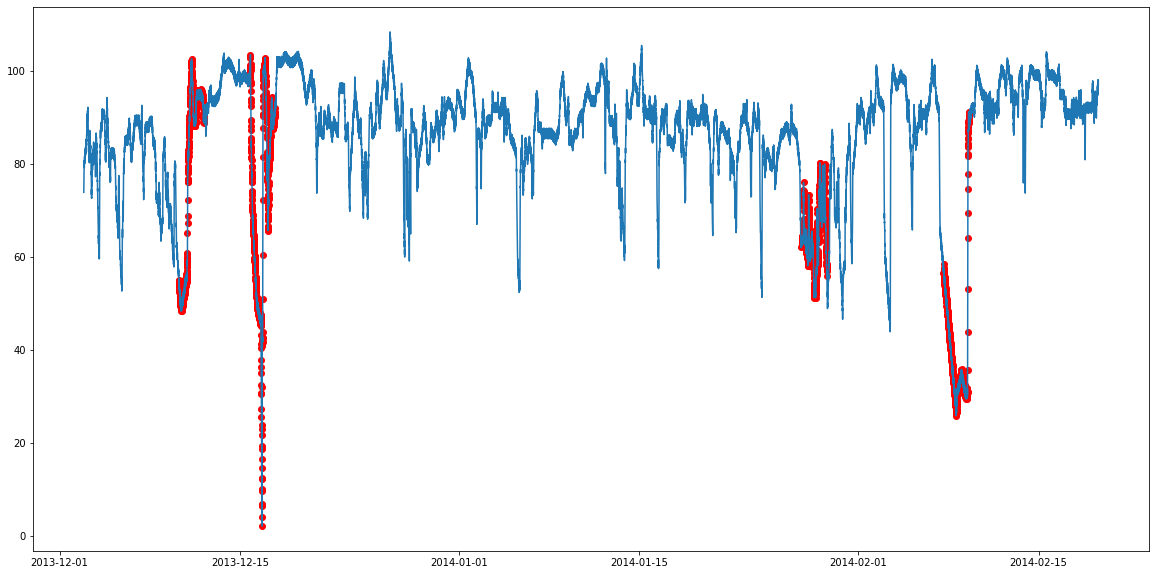

In [11]:
dfa = df[df.anomaly == 1]
rcParams['figure.figsize'] = (20, 10)
fig, ax = plt.subplots()
ax.plot(df.timestamp, df.value)
ax.scatter(dfa.timestamp, dfa.value, c = 'red', label = 'Outlier')

<BarContainer object of 2 artists>

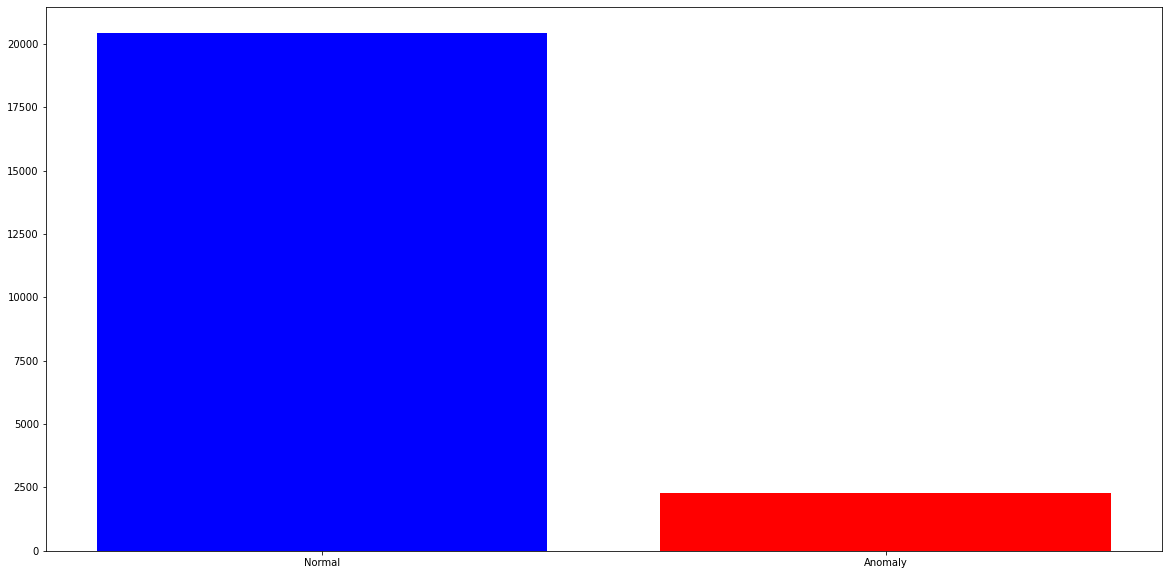

In [12]:
plt.bar(df.anomaly.unique(), df.anomaly.value_counts(), tick_label = ["Normal", "Anomaly"], color = ["blue", "red"])

In [13]:
df.anomaly.value_counts()

0    20427
1     2268
Name: anomaly, dtype: int64

Now let's extract useful information but first of all let's drop the duplicated value that we found last time

In [14]:
df[df.duplicated(subset = ['timestamp'])]

,timestamp,value,anomaly
10149,2014-01-07 02:00:00,94.139723,0
10150,2014-01-07 02:05:00,94.111970,0
10151,2014-01-07 02:10:00,94.638723,0
10152,2014-01-07 02:15:00,93.270907,0
10153,2014-01-07 02:20:00,93.890249,0
10154,2014-01-07 02:25:00,93.396627,0
10155,2014-01-07 02:30:00,94.199300,0
10156,2014-01-07 02:35:00,94.125420,0
10157,2014-01-07 02:40:00,93.530827,0
10158,2014-01-07 02:45:00,92.784720,0


In [15]:
df.drop_duplicates(subset = ['timestamp'], keep = 'last', inplace = True)

In [16]:
# extracting timestamp
df['timestamp'] = pd.to_datetime(df.timestamp)
# df['date'] = pd.to_datetime(df.timestamp).dt.date
df['hours'] = df.timestamp.dt.hour
df['day'] = df.timestamp.dt.dayofweek
df.head()

,timestamp,value,anomaly,hours,day
0,2013-12-02 21:15:00,73.967322,0,21,0
1,2013-12-02 21:20:00,74.935882,0,21,0
2,2013-12-02 21:25:00,76.124162,0,21,0
3,2013-12-02 21:30:00,78.140707,0,21,0
4,2013-12-02 21:35:00,79.329836,0,21,0


In [17]:
# Grouping by average per hourday
df_final = df.join(df.groupby(['day', 'hours'])['value'].mean(), on=['day', 'hours'], rsuffix = '_avg')
df_final.head()

,timestamp,value,anomaly,hours,day,value_avg
0,2013-12-02 21:15:00,73.967322,0,21,0,86.047808
1,2013-12-02 21:20:00,74.935882,0,21,0,86.047808
2,2013-12-02 21:25:00,76.124162,0,21,0,86.047808
3,2013-12-02 21:30:00,78.140707,0,21,0,86.047808
4,2013-12-02 21:35:00,79.329836,0,21,0,86.047808


In [18]:
# find difference between 2 value (1st and 2nd) and its value with the avg
diff = [0]
avg_diff = []
for a in range(0, len(df_final.value)):
    try:
        diff.append(abs(np.float64(df_final['value'].iloc[[a+1]].to_numpy() - df_final['value'].iloc[[a]].to_numpy())))
        avg_diff.append(abs(np.float64(df_final['value'].iloc[[a]].to_numpy() - df_final['value_avg'].iloc[[a]].to_numpy())))
    except:
        avg_diff.append(abs(np.float64(df_final['value'].iloc[[a]].to_numpy() - df_final['value_avg'].iloc[[a]].to_numpy())))

In [19]:
df_final['diff'] = diff
df_final['avg_diff'] = avg_diff

In [20]:
df_final.head()

,timestamp,value,anomaly,hours,day,value_avg,diff,avg_diff
0,2013-12-02 21:15:00,73.967322,0,21,0,86.047808,0.000000,12.080486
1,2013-12-02 21:20:00,74.935882,0,21,0,86.047808,0.968560,11.111926
2,2013-12-02 21:25:00,76.124162,0,21,0,86.047808,1.188280,9.923646
3,2013-12-02 21:30:00,78.140707,0,21,0,86.047808,2.016546,7.907101
4,2013-12-02 21:35:00,79.329836,0,21,0,86.047808,1.189128,6.717972


# Feature Extraction

In [21]:
df_final.head()

,timestamp,value,anomaly,hours,day,value_avg,diff,avg_diff
0,2013-12-02 21:15:00,73.967322,0,21,0,86.047808,0.000000,12.080486
1,2013-12-02 21:20:00,74.935882,0,21,0,86.047808,0.968560,11.111926
2,2013-12-02 21:25:00,76.124162,0,21,0,86.047808,1.188280,9.923646
3,2013-12-02 21:30:00,78.140707,0,21,0,86.047808,2.016546,7.907101
4,2013-12-02 21:35:00,79.329836,0,21,0,86.047808,1.189128,6.717972


Now we can prepare our data

In [22]:
dfs = df_final[['value', 'hours', 'day', 'diff', 'avg_diff']]
dfs.head()

,value,hours,day,diff,avg_diff
0,73.967322,21,0,0.000000,12.080486
1,74.935882,21,0,0.968560,11.111926
2,76.124162,21,0,1.188280,9.923646
3,78.140707,21,0,2.016546,7.907101
4,79.329836,21,0,1.189128,6.717972


# Models

In [23]:
from sklearn.ensemble import IsolationForest

In [24]:
# Take useful feature and standardize them
IF = IsolationForest(random_state=42, contamination=0.13, n_estimators=200)
y_pred = IF.fit_predict(dfs)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


In [25]:
if_df = pd.DataFrame()
# New Outliers Column
if_df['outliers'] = [1 if i==-1 else 0 for i in y_pred]

# Get Anomaly Score
score = IF.decision_function(dfs) * -1

# New Anomaly Score column
if_df['score'] = score
if_df.head()

,outliers,score
0,1,0.013233
1,0,-0.011392
2,0,-0.015418
3,1,0.023055
4,0,-0.030852


In [26]:
f1 = f1_score(df_final['anomaly'], if_df['outliers'])
cm = confusion_matrix(df_final['anomaly'], if_df['outliers'])
print(f"F1 Score = {f1}")
print("\nConfusion Matrix")
print(cm)

F1 Score = 0.5221391604370328

Confusion Matrix
[[18828  1587]
 [  906  1362]]


From isolation forest, we could do the anomaly detection with the 0.52 F1 Score !!